## 1. Dependencies/Data Read

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import re
import seaborn as sns
import datetime
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 100
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.DataFrame(pd.read_csv("Kickstarter.csv"))
for i in range(1,10):
    df = df.append(pd.read_csv("Kickstarter00" + str(i) + ".csv"))
for i in range(11,49):
    df = df.append(pd.read_csv("Kickstarter0" + str(i) + ".csv"))
df = df.reset_index(drop=True)

## 2. Data Cleaning

In [4]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions
0,80,I will be an artist-in-residence at Elsewhere ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3596,US,1325980505,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334866560,False,1.00,2800.00,1562040083,False,1332969260,Elsewhere Studios artist-in-residency program!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3596.00,"{""background_image_opacity"":0.8,""should_show_f...",elsewhere-studios-artist-in-residency-program,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334866560,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3596.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
1,47,We are looking to bring a Visiting Sculptor fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4117,US,1330727362,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334959598,False,1.00,3900.00,1437561817,False,1332972398,Martin Luther King Jr. Sculpture on Campus!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4117.00,"{""background_image_opacity"":0.8,""should_show_f...",martin-luther-king-jr-sculpture-on-campus,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334959598,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4117.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
2,80,Surrealistic oil paintings capturing the metam...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3125,US,1332598567,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334635140,False,1.00,750.00,574125813,False,1332975679,EMERGENCE: Surreal Oil Paintings by J.J. Long,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3125.00,"{""background_image_opacity"":0.8,""should_show_f...",emergence-surreal-oil-paintings-by-jj-long,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334635143,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3125.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
3,82,1000 Artists is a public art-making installati...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4586,US,1330926084,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1336440145,False,1.00,4500.00,858990141,False,1332984145,1000 Artists: Presidential Inauguration 2013,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4586.00,"{""background_image_opacity"":0.8,""should_show_f...",1000-artists-presidential-inauguration-2013,https://www.kickstarter.com/discover/categorie...,True,False,successful,1336440145,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4586.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",1036,US,1332476607,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1333421843,False,1.00,1000.00,566704999,False,1332989843,P.M.A.F.T.W.,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",1036.00,"{""background_image_opacity"":0.8,""should_show_f...",pmaftw,https://www.kickstarter.com/discover/categorie...,True,False,successful,1333421843,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",1036.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN


In [5]:
df.shape

(191573, 37)

In [6]:
df.isnull().sum()

backers_count                    0
blurb                           11
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
fx_rate                          0
goal                             0
id                               0
is_starrable                     0
launched_at                      0
name                             1
photo                            0
pledged                          0
profile                          0
slug                             0
source_url                       0
spotlight                        0
staff_pick                       0
state                            0
state_changed_at                 0
static_usd_rate     

In [7]:
df.location=df.location.fillna('short_name":"Undefined')

cat, sub, loc, dtime, ddate, ltime, ldate = [],[],[],[],[],[],[]

for i in range(0,len(df)):
    sub.append(re.search('(?<="name":")\w+(.[a-zA-Z]+)(.[a-zA-Z]+)?', df.category.iloc[i]).group())
    cat.append(re.search('(?<="slug":")\w+', df.category.iloc[i]).group().capitalize())
    loc.append(re.search('(?<=short_name":")(....)?[-]?([a-zA-Z]+)?\s?[-]?([a-zA-Z]+)?', df.location.iloc[i]).group())
    dtime.append(datetime.datetime.fromtimestamp(df.deadline[i]).strftime('%H'))
    ddate.append(datetime.datetime.fromtimestamp(df.deadline[i]).strftime('%Y-%m-%d'))
    ltime.append(datetime.datetime.fromtimestamp(df.launched_at[i]).strftime('%H'))
    ldate.append(datetime.datetime.fromtimestamp(df.launched_at[i]).strftime('%Y-%m-%d'))
    
df['category'], df['subcategory'], df['location'], df['dtime'], df['ddate'], df['ltime'], df['ldate'] = cat, sub, loc, dtime, ddate, ltime, ldate

In [8]:
df = df.drop(['blurb', 'converted_pledged_amount','created_at', 'creator', 'currency_symbol', 'currency_trailing_code', 
              'current_currency', 'id', 'name', 'photo', 'profile', 'slug', 'source_url','state_changed_at', 'static_usd_rate',
              'urls','usd_type','friends', 'is_backing', 'is_starred','permissions','deadline','launched_at'], axis=1)

In [9]:
df.isnull().sum()

backers_count            0
category                 0
country                  0
currency                 0
disable_communication    0
fx_rate                  0
goal                     0
is_starrable             0
pledged                  0
spotlight                0
staff_pick               0
state                    0
usd_pledged              0
location                 0
subcategory              0
dtime                    0
ddate                    0
ltime                    0
ldate                    0
dtype: int64

In [10]:
df.state.unique()

array(['successful', 'live', 'canceled', 'failed', 'suspended'],
      dtype=object)

In [11]:
df.state=[i.replace('canceled', 'failed') for i in df.state]
df.state=[i.replace('suspended', 'failed') for i in df.state]

In [12]:
df.head()

,backers_count,category,country,currency,disable_communication,fx_rate,goal,is_starrable,pledged,spotlight,staff_pick,state,usd_pledged,location,subcategory,dtime,ddate,ltime,ldate
0,80,Art,US,USD,False,1.00,2800.00,False,3596.00,True,False,successful,3596.00,Paonia,Mixed Media,13,2012-04-19,14,2012-03-28
1,47,Art,US,USD,False,1.00,3900.00,False,4117.00,True,False,successful,4117.00,Bakersfield,Art,15,2012-04-20,15,2012-03-28
2,80,Art,US,USD,False,1.00,750.00,False,3125.00,True,False,successful,3125.00,Lowell,Painting,20,2012-04-16,16,2012-03-28
3,82,Art,US,USD,False,1.00,4500.00,False,4586.00,True,False,successful,4586.00,Washington,Public Art,18,2012-05-07,18,2012-03-28
4,31,Art,US,USD,False,1.00,1000.00,False,1036.00,True,False,successful,1036.00,Portland,Painting,19,2012-04-02,19,2012-03-28


# 3. Data Exploration

In [13]:
df.groupby('state').state.count()

state
failed         81521
live            6578
successful    103474
Name: state, dtype: int64

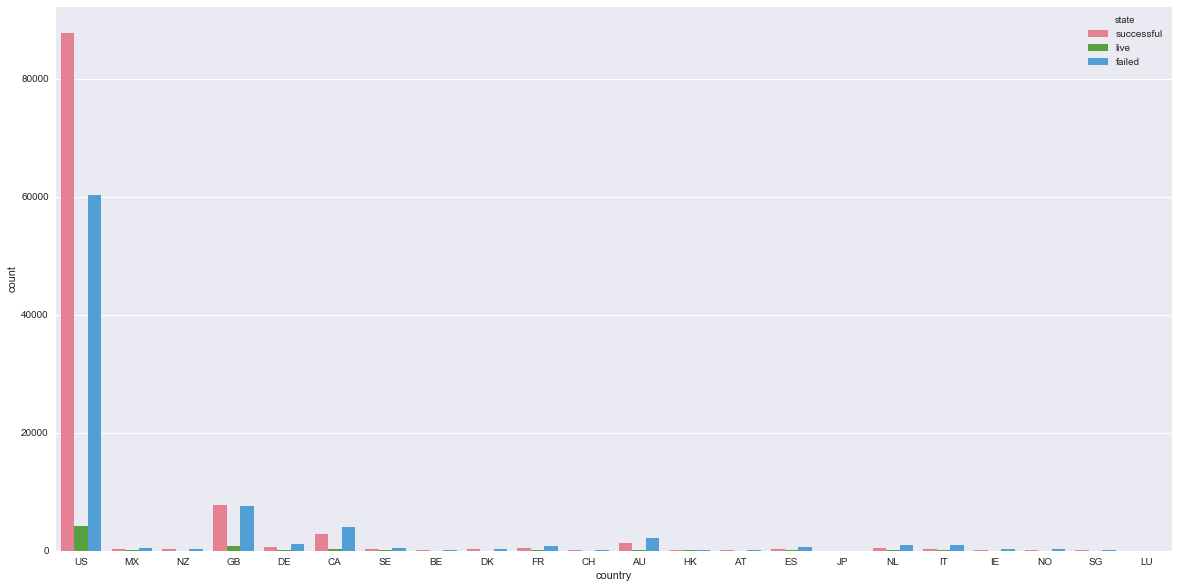

In [60]:
plt.figure(figsize=(20,10))
sns.countplot(x="country", hue="state", data=df, palette='husl')

In [61]:
x=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000].index)
y=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000])

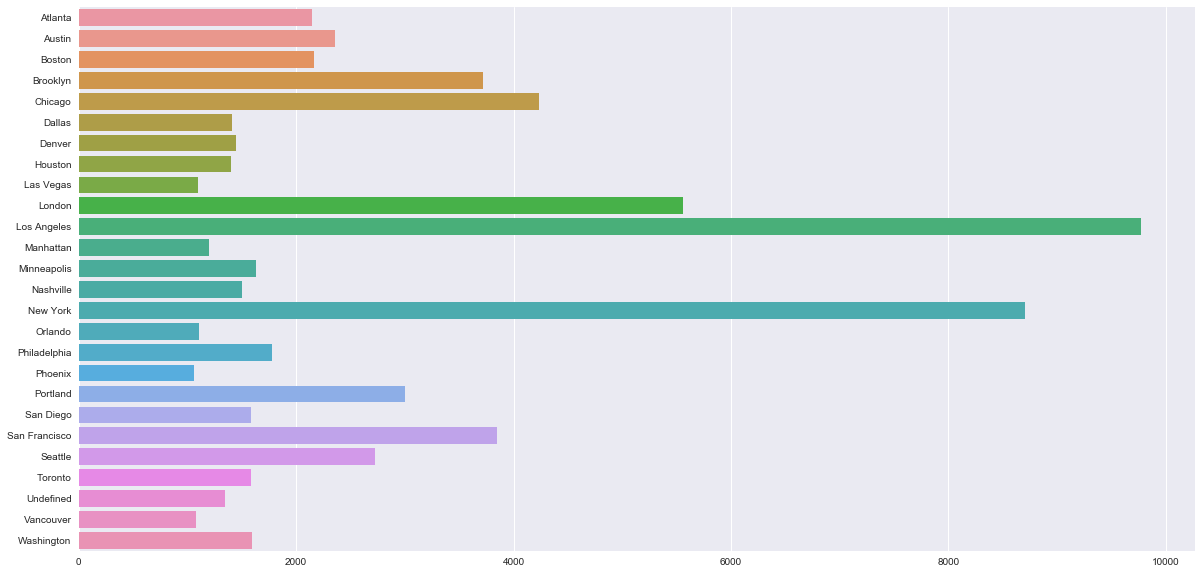

In [62]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
sns.barplot(y=x,x=y,orient="h")